In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

c:\Users\banfi\anaconda3\envs\pytorch-env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv("task1_data.txt")
train_labels = pd.read_csv("task1_train_label.txt", header=None, sep="\t", names=["order", "label"])
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "label"])
test_query = pd.read_csv("task1_test_query.txt",header=None, names=["order"])

In [4]:
train_df = df.merge(train_labels, on="order")
valid_df = df.merge(valid_labels, on="order")
test_df = df.merge(test_query, on="order")

In [5]:
train_df["label"].value_counts(dropna=False)

label
1    1116464
0     431381
2     345549
Name: count, dtype: int64

# Baseline

In [8]:
def create_return_df(df, labels, product_stats):
    df = df.merge(product_stats["return_rate"], how='left', right_index=True, left_on='product')
    df["no_return_rate"] = 1 - df["return_rate"]
    order_return_rate = df.groupby('order')['return_rate'].prod()
    order_no_return_rate = df.groupby('order')['no_return_rate'].prod()
    return_df = pd.concat([order_return_rate, order_no_return_rate], axis=1, keys=['order_return_rate', 'order_no_return_rate'])
    return_df["some_return"] = 1 - return_df["order_no_return_rate"] - return_df["order_return_rate"]
    return_df = return_df.merge(labels, on="order")
    return return_df

<Axes: >

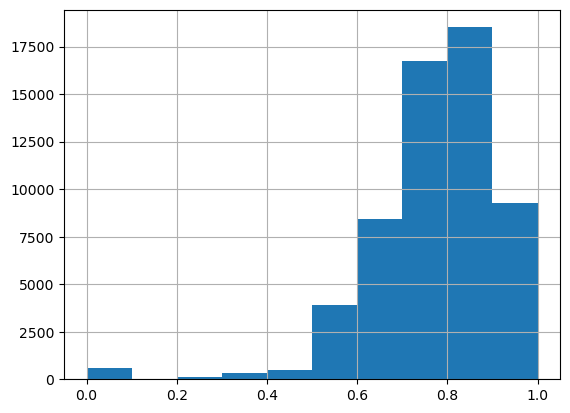

In [9]:
# Calculate how many times each product has been in an order that was returned/partially returned
# Return probability is the ratio of returns/partial returns and all occurences of the product
product_stats = train_df.groupby('product').agg(
    total_count=('product', 'count'),
    return_1_or_2_count=('label', lambda x: (x==1).sum() + (x==2).sum())
).reset_index(drop=True)
product_stats['return_rate'] = product_stats['return_1_or_2_count'] / product_stats['total_count']
product_stats["return_rate"].hist()

In [10]:
import numpy as np

valid_return_df = create_return_df(valid_df, valid_labels, product_stats)# Prediction is the highest of the three probabilities
conditions = [
    (valid_return_df['order_no_return_rate'] > valid_return_df['some_return']) & (valid_return_df['order_no_return_rate'] > valid_return_df['order_return_rate']),
    (valid_return_df['some_return'] > valid_return_df['order_no_return_rate']) & (valid_return_df['some_return'] > valid_return_df['order_return_rate']),
    (valid_return_df['order_return_rate'] > valid_return_df['order_no_return_rate']) & (valid_return_df['order_return_rate'] > valid_return_df['some_return'])
]

choices = [0, 1, 2]

valid_return_df['prediction'] = np.select(conditions, choices, default=np.nan)

In [11]:
# Accuracy calculation
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.4503717311602566

# Baseline - Simple model

In [12]:
train_return_df = create_return_df(train_df, train_labels, product_stats)
valid_return_df = create_return_df(valid_df, valid_labels, product_stats)

In [18]:
from sklearn.linear_model import SGDClassifier
feature_names = ["order_return_rate", "order_no_return_rate", "some_return"]
features = train_return_df[feature_names]
labels = train_return_df["label"]
model = SGDClassifier()
model.fit(features, labels)
score = model.score(features, labels)
score

0.6057735982369665

In [19]:
valid_return_df["prediction"] = model.predict(valid_return_df[feature_names])

In [20]:
# Accuracy calculation
valid_return_df["correct"] = valid_return_df["prediction"] == valid_return_df["label"]
accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
accuracy

0.5812744844045629